# Lab Assignment 4, Exercise 1
## Austin Booth

Link:

### Part 3

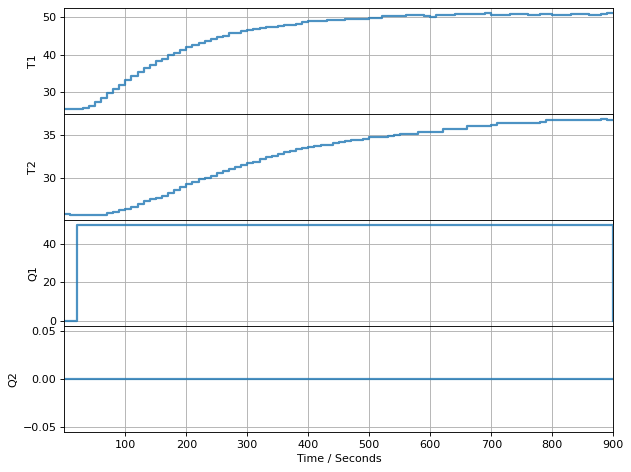

TCLab disconnected successfully.


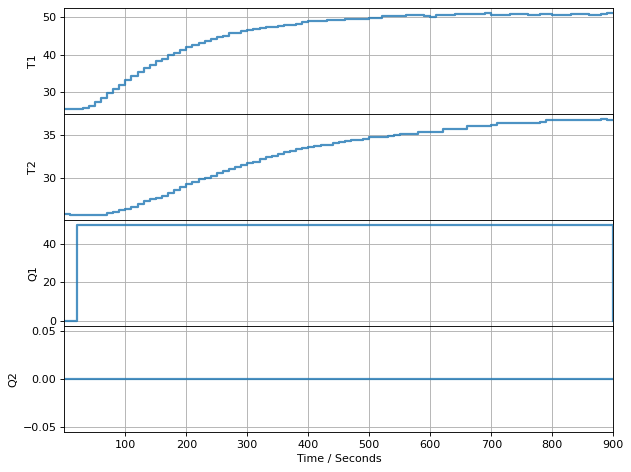

In [11]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import tclab
from tclab import TCLab, clock, Historian, Plotter

# define function to set u1 as step input (change to u=50% at t=20 s)
def u1(t):
    if t <= 20:
        return 0
    elif t <= 900:
        return 50
    else:
        return 0
    
# use u1 to set heating behavior and record data
with TCLab() as lab:
    # set P1 and P2 as specified
    lab.P1 = 255
    lab.P2 = 50
    # set up plotter
    h = Historian(lab.sources)
    p = Plotter(h, 900)
    
    # input u1 function to heater
    for t in clock(900, 10):
        lab.U1 = u1(t)
        p.update(t)        

# save data
h.to_csv('lab4data1.csv')

,T1,T2,Q1,Q2
Time,,,,
0.00,25.636,25.861,0.0,0.0
10.00,25.475,25.797,0.0,0.0
20.01,25.475,25.797,50.0,0.0
30.01,25.732,25.732,50.0,0.0
40.00,26.377,25.732,50.0,0.0
...,...,...,...,...
860.00,50.740,36.689,50.0,0.0
870.01,50.644,36.722,50.0,0.0
880.01,50.869,36.883,50.0,0.0


<AxesSubplot:xlabel='time / seconds'>

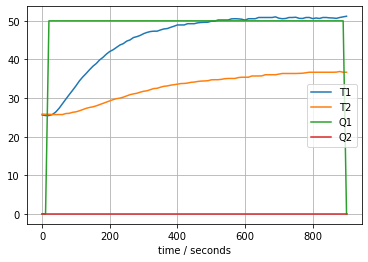

In [12]:
# make sure csv file reads and plots correctly

# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# create data file
expt = pd.read_csv('lab4data1.csv')

# set time index
expt = expt.set_index("Time")
t_expt = expt.index

# display data in tabular format
display(expt)

# simple plotting
expt.plot(grid=True, xlabel="time / seconds")

Slight decrease in T2 is observed near end of experiment - assume these results are good enough to approximate steady state T2 behavior.

### Part 4

In [13]:
# define function to plot and compare two data sets
def plot_data(expt, pred):
    t_expt = expt.index
    
    # create a 3 x 1 grid of plot axes
    fig, ax = plt.subplots(3, 1, figsize=(10,8))
    
    # first plot axes
    ax[0].scatter(t_expt, expt["T1"], label="T1 expt", marker='.')
    ax[0].scatter(t_expt, expt["T2"], label="T2 expt", marker='.')
    ax[0].plot(t_expt, pred["T1"], label="T1 pred")
    ax[0].plot(t_expt, pred["T2"], label="T2 pred")
    ax[0].set_ylabel("deg C")
    ax[0].set_title("temperature response")

    # second plot axes
    ax[1].scatter(t_expt, expt["Q1"], label="Q1 expt", marker='.')
    ax[1].scatter(t_expt, expt["Q2"], label="Q2 expt", marker='.')
    ax[1].plot(t_expt, pred["Q1"], label="Q1 pred")
    ax[1].plot(t_expt, pred["Q2"], label="Q2 pred")
    ax[1].set_ylim([0, 100])
    ax[1].set_ylabel("percent")
    ax[1].set_title("heater power")
    
    # third plot axes
    ax[2].plot(t_expt, pred["T1"]-expt["T1"], label="T1 error")
    ax[2].plot(t_expt, pred["T2"]-expt["T2"], label="T1 error")
    ax[2].set_title("temperature prediction error")
    
    # things to do for every plot axes
    for a in ax:
        a.grid(True)
        a.set_xlabel("time / seconds")
        a.legend()
        
    plt.tight_layout()
    
    # return list of axes so to allow additional information to be added
    return ax

Time
0.00      -0.261000
10.00     -0.197000
20.01      1.675815
30.01      3.491038
40.00      5.126800
            ...    
860.00    17.821629
870.01    17.795108
880.01    17.640163
890.01    17.839827
900.01    17.845126
Name: T2, Length: 91, dtype: float64

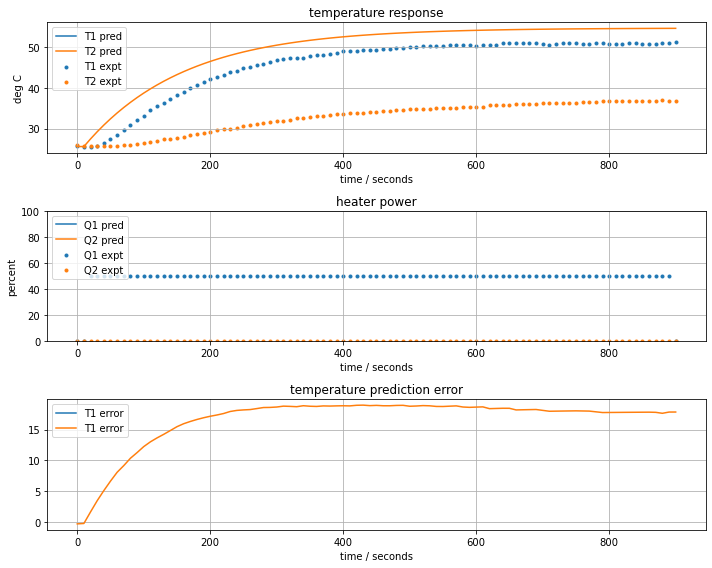

In [16]:
# fit FOPDT model with respect to Q1 and T2

# parameter values and units
T_amb = 25.6                 # deg C; determined based on average of heaters' ambient T
u1bar = expt["Q1"].mean()
t_expt = expt.index

# adjustable parameters
K = 0.6
tau = 150
t_delay = 10

def model_first_order_delay(param, plot=False):
    K, tau, t_delay = param    
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T2"] = [T_amb + K*u1bar*(1 - np.exp(-(t-t_delay)/tau)) if t > t_delay else T_amb for t in t_expt]
    if plot:
        plot_data(expt, pred)
    return pred["T2"] - expt["T2"]
    
model_first_order_delay([K, tau, t_delay], True)

K = 0.2514013766240045,  tau = 305.166850814179, time delay = 84.65189320122114


Time
0.00     -0.261000
10.00    -0.197000
20.01    -0.197000
30.01    -0.132000
40.00    -0.132000
            ...   
860.00    0.108701
870.01    0.106615
880.01   -0.024499
890.01    0.198424
900.01    0.226414
Name: T2, Length: 91, dtype: float64

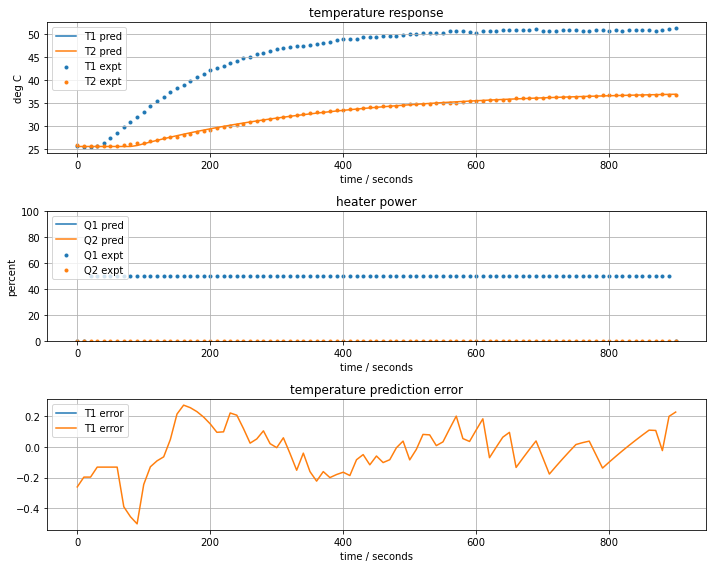

In [17]:
# optimize and report parameters using least squares
from scipy.optimize import least_squares
results = least_squares(model_first_order_delay,  [K, tau, t_delay])
K, tau, t_delay = results.x
print(f"K = {K},  tau = {tau}, time delay = {t_delay}")
model_first_order_delay(results.x, True)

Steady-state gain (K) = 0.2514 degrees C / percent power

Time constant (T) = 305.2 seconds

Time delay (tau) = 84.65 seconds

### Part 5

In [18]:
# calculate Kp using Astrom and Murray
Kp = (0.15*t_delay + 0.35 * tau) / (K * t_delay)   # units 1/K = percent power / degrees C

# calculate Ki using Astrom and Murray
Ki = (0.46*t_delay + 0.02 * tau) / (K * t_delay**2)  # units percent power / deg C * s

print('Kp =',Kp,'% power / deg C.')
print('Ki =',Ki,'% power / deg C*s.')

Kp = 5.615469128865585 % power / deg C.
Ki = 0.025002780624030288 % power / deg C*s.


### Part 6

In [19]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

def experiment_2(controller, t_final=1000, t_step=5,
               SP=lambda t: 30 if t >= 20 else 0,    # sets SP to 30 C at t = 20 s
               DV=lambda t: 20 if t >= 300 else 0): # sets DV to 20% at t = 300 s
    
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 255
        lab.P2 = 50
        next(controller)

        # event loop
        for t in clock(t_final, t_step):
            T2 = lab.T2
            U1 = lab.Q1()                            # <==== new line
            U1 = controller.send((t_step, SP(t), T2, U1))    # <==== send U1 to controller 
            lab.Q1(U1)
            lab.Q2(DV(t))
            p.update(t)    

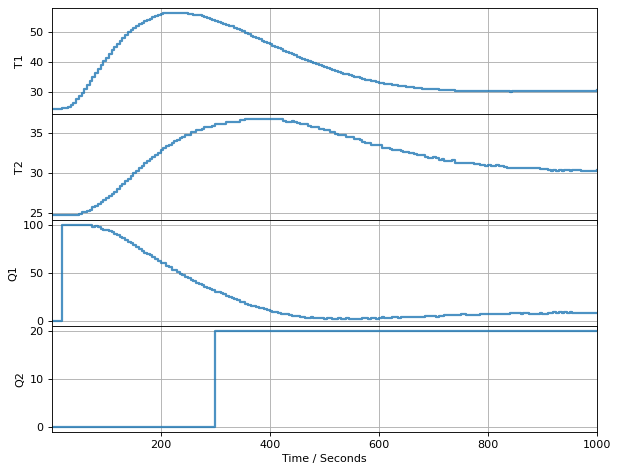

TCLab disconnected successfully.


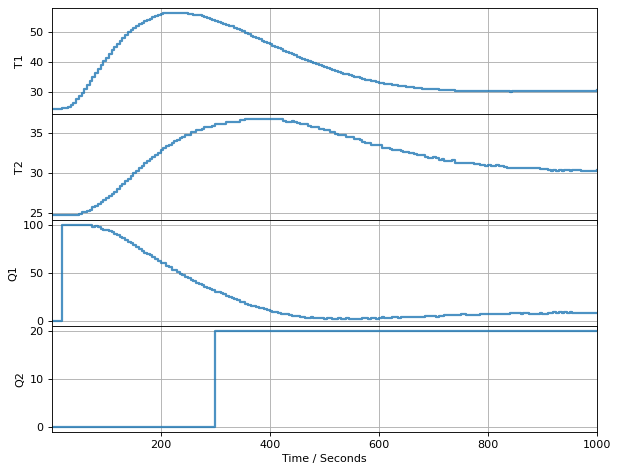

In [20]:
# add anti-integral windup feature.

def PI_antiwindup(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    while True:
        t_step, SP, PV, MV = yield MV       # <= now gets MV from experiment
        e = PV - SP
        MV += -Kp*(e - e_prev) - t_step*Ki*e 
        MV = max(MV_min, min(MV_max, MV))   # <= range limits
        e_prev = e

# run with Kp and Ki as determined above
print('Kp =',Kp)
print('Ki =',Ki)
experiment_2(PI_antiwindup(Kp, Ki))

The controller was ineffective in quickly reaching a setpoint of 30 deg C. It is likely that tuning the FOPDT parameters (and Kp and Ki) to a step test where the maximum Q1 was 50% made the model underestimate T2's response to full-power Q1. As a result, the PI control for Q1 decayed more slowly than it should have, and T2 was overestimated by over 6 degrees as a combination of this overshoot and the introduced disturbance. However, eventually (by around 1000 seconds), the controller did manage to return T2 to a value close to the set point, reversing the effects of both the overshoot and the disturbance.